In [ ]:
import numpy as np
import argopy
from argopy import DataFetcher
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from datetime import datetime
from cartopy.geodesic import Geodesic
from scipy import linalg
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import haversine_distances
from matplotlib.patches import Circle

import ArgoHeatContentDataCollater as ahdc
import ArgoGPR as ag
import seaborn as sns
from scipy import stats

# TESTING OUT ACTUAL CALCULATIONS WITH A MOVING WINDOW GPR AND USING OCEAN HEAT CONTENT DISCRETE CALCULATIONS

In [2]:
# 1. LOAD DATA
# Adjust path to your folder
df_argo = ahdc.load_argo_data_advanced(
    nc_dir='/home/avik2007/ArgoEBUSAnalysis/ArgoData/', 
    start_date='2017-01-01', 
    end_date='2019-01-01', # Grab a few months to test
    lat_bounds=[30, 40], 
    lon_bounds=[-126, -119],
    depth_bounds = [0, 500],
)


📂 FOUND LOCAL DATASET: /home/avik2007/ArgoEBUSAnalysis/ArgoData/argo_2017-01-01_to_2019-01-01_lat30_40_lon-126_-119_z0_500.pkl
   Loading processed DataFrame...
   ✅ Loaded 70432 profile measurements from disk.


(array([72., 54., 54., 46., 44., 27., 27., 27., 18., 27.]),
 array([  3.97149196,  52.30817719, 100.64486243, 148.98154766,
        197.31823289, 245.65491813, 293.99160336, 342.32828859,
        390.66497383, 439.00165906, 487.33834429]),
 <BarContainer object of 10 artists>)

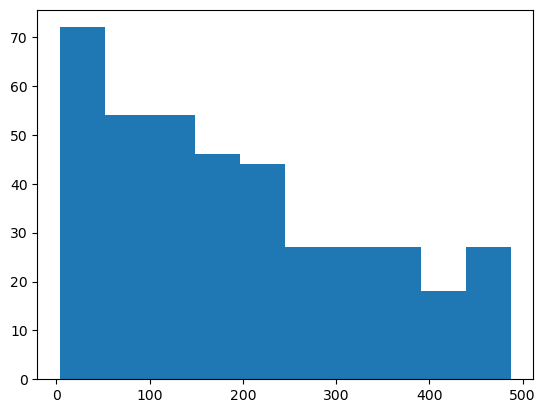

In [3]:
%matplotlib inline
depths = df_argo[df_argo['float_id'] == '4900832']['depth'].to_numpy()
plt.hist(depths)


In [4]:
df_ohc_500m = ahdc.estimate_ohc_from_raw_bins(df_argo, depth_max = 5000, resolution_lat=0.05, resolution_lon = 0.05, min_coverage_pct= 0.1)

📦 BINNING RAW DATA: 0.05° x 0.05° x 30 days...
   ⚡ Collapsing 70432 points into 4D Grid (Time/Lat/Lon/Depth)...
   🌊 Integrating 329 valid profiles...
✅ DONE. Generated 329 OHC estimates.


In [5]:
df_ohc_500m

,time_bin,lat_bin,lon_bin,ohc,ohc_per_m,n_raw_points
0,0.0,30.025,-125.575,2.117989e+10,4.235978e+06,44
1,0.0,30.175,-125.675,2.144057e+10,4.288114e+06,44
2,0.0,30.375,-125.725,2.010845e+10,4.021691e+06,44
3,0.0,30.775,-119.675,1.897675e+10,3.795350e+06,41
4,0.0,30.875,-119.775,1.948350e+10,3.896700e+06,40
...,...,...,...,...,...,...
324,690.0,34.875,-122.225,1.788827e+10,3.577654e+06,256
325,720.0,31.275,-119.925,1.908868e+10,3.817735e+06,40
326,720.0,33.875,-122.425,1.732013e+10,3.464027e+06,255
327,720.0,34.725,-122.375,1.744383e+10,3.488765e+06,256


In [6]:
len(df_argo['float_id'].unique())

13

In [7]:
df_ohc_500m

,time_bin,lat_bin,lon_bin,ohc,ohc_per_m,n_raw_points
0,0.0,30.025,-125.575,2.117989e+10,4.235978e+06,44
1,0.0,30.175,-125.675,2.144057e+10,4.288114e+06,44
2,0.0,30.375,-125.725,2.010845e+10,4.021691e+06,44
3,0.0,30.775,-119.675,1.897675e+10,3.795350e+06,41
4,0.0,30.875,-119.775,1.948350e+10,3.896700e+06,40
...,...,...,...,...,...,...
324,690.0,34.875,-122.225,1.788827e+10,3.577654e+06,256
325,720.0,31.275,-119.925,1.908868e+10,3.817735e+06,40
326,720.0,33.875,-122.425,1.732013e+10,3.464027e+06,255
327,720.0,34.725,-122.375,1.744383e+10,3.488765e+06,256


🚀 RUNNING ROLLING VALIDATION...
🕵️ STARTING ROLLING ANALYSIS
   Window: 120d | Step: 30d | Validation: 20%
   Targets: RMSRE < 0.05 | Std Z in (0.9, 1.1)
   Window 0-120: ✅ RMSRE=1.355% | ✅ Z=0.99
   Window 30-150: ✅ RMSRE=2.011% | ✅ Z=1.01
   Window 60-180: ✅ RMSRE=3.704% | ✅ Z=0.99
   Window 90-210: ✅ RMSRE=3.757% | ✅ Z=1.08
   Window 120-240: ✅ RMSRE=3.560% | ✅ Z=1.05
   Window 150-270: ✅ RMSRE=3.437% | ✅ Z=0.98
   Window 180-300: ✅ RMSRE=3.866% | ✅ Z=1.06
   Window 210-330: ✅ RMSRE=4.127% | ✅ Z=1.01
   Window 240-360: ✅ RMSRE=3.457% | ✅ Z=1.01
   Window 270-390: ✅ RMSRE=2.436% | ✅ Z=0.97
   Window 300-420: ✅ RMSRE=3.249% | ✅ Z=1.06
   Window 330-450: ✅ RMSRE=2.004% | ✅ Z=0.93
   Window 360-480: ✅ RMSRE=2.127% | ✅ Z=1.01


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 5.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


   Window 390-510: ✅ RMSRE=2.099% | ✅ Z=0.99


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 5.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


   Window 420-540: ✅ RMSRE=3.126% | ✅ Z=0.99
   Window 450-570: ✅ RMSRE=3.500% | ✅ Z=1.05
   Window 480-600: ✅ RMSRE=1.780% | ✅ Z=0.95
   Window 510-630: ✅ RMSRE=4.427% | ✅ Z=0.99


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 5.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 5.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


   Window 540-660: ✅ RMSRE=3.144% | ✅ Z=1.01
   Window 570-690: ✅ RMSRE=3.613% | ✅ Z=0.99
   Window 600-720: ✅ RMSRE=3.686% | ✅ Z=1.07


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 5.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


   Window 630-750: ✅ RMSRE=2.925% | ✅ Z=1.00


/tmp/ipykernel_64891/2951394830.py:84: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64891/2951394830.py:84: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64891/2951394830.py:84: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64891/2951394830.py:84: UserWarning: Glyph 128276 (\N{BELL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.


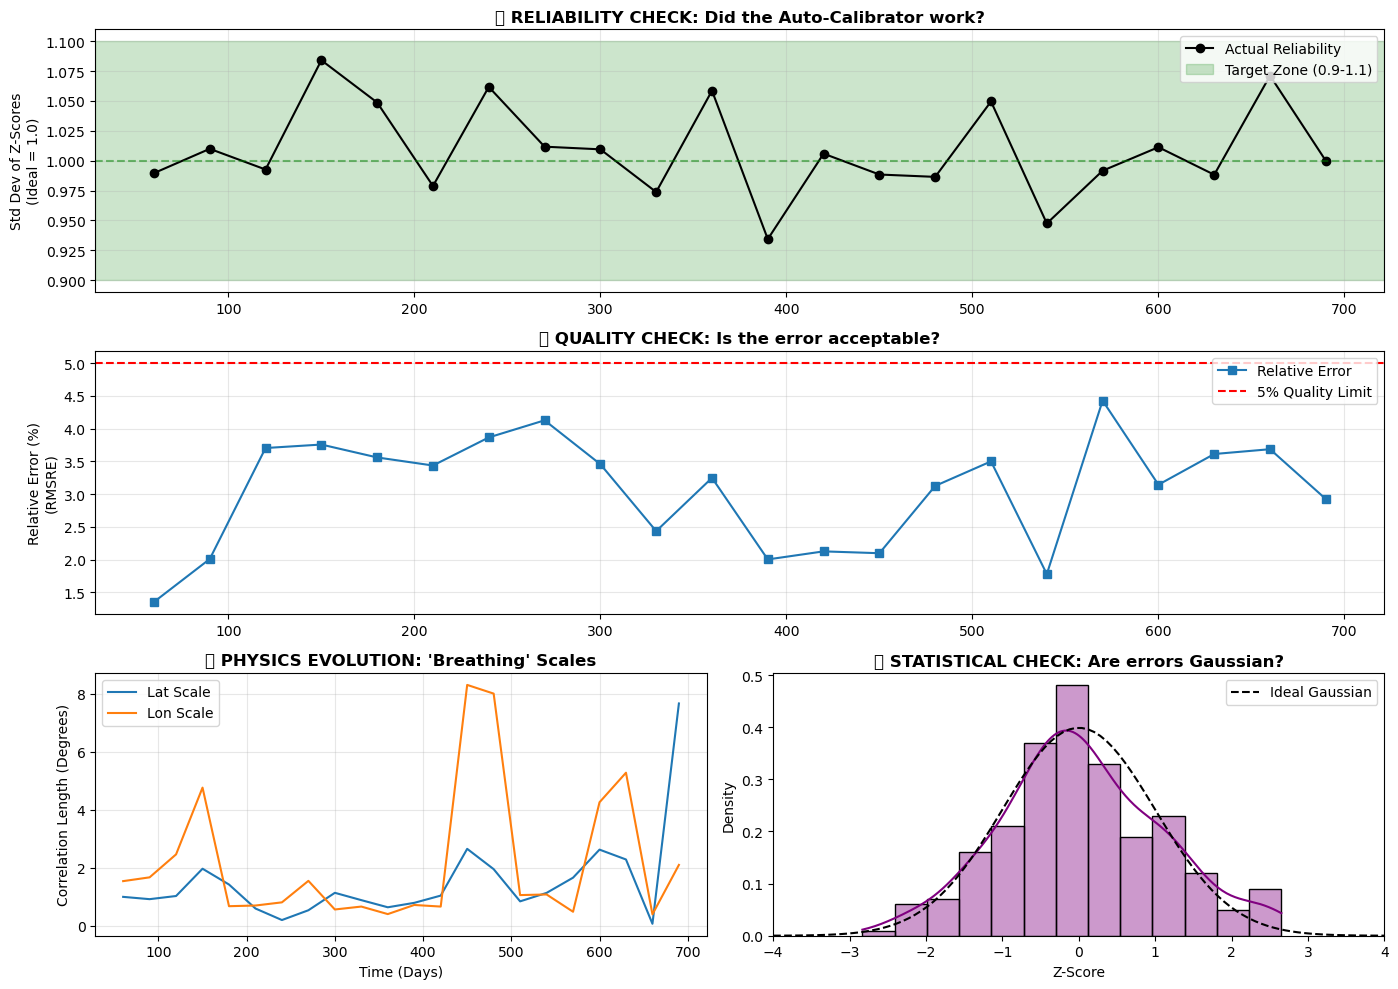


📊 DASHBOARD SUMMARY:
   - Windows Processed:   22
   - Reliability Pass Rate: 100.0% (Windows inside 0.9-1.1 Z)
   - Quality Pass Rate:     100.0% (Windows < 5% Error)


In [8]:
print("🚀 RUNNING ROLLING VALIDATION...")
results_df, cv_details = ag.analyze_rolling_correlations(
    df_ohc_500m,
    feature_cols=['lat_bin', 'lon_bin'], # 2D Space
    # Target variable
    
    # Validation Config
    k_fold_data_percent=20,      # 20% holdout per window
    window_size_days=120,         # 3-Month Window
    step_size_days=30,           # Monthly steps
    
    # Auto-Calibration Settings
    auto_tune=True,              # Find best physics
    auto_calibrate=True,         # Fix noise levels
    target_z_bounds=(0.9, 1.1),  # The "Green Zone"
    target_rmsre=0.05            # Quality warning threshold (5%)
)

# ==============================================================================
# 2. VISUALIZE THE CALIBRATION (The Proof)
# ==============================================================================
if not results_df.empty:
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2)
    
    # --- PLOT A: RELIABILITY (Std Z-Score) ---
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(results_df['window_center'], results_df['std_z'], 
             marker='o', color='k', label='Actual Reliability')
    
    # Draw the "Green Zone" (Target Bounds)
    ax1.axhspan(0.9, 1.1, color='green', alpha=0.2, label='Target Zone (0.9-1.1)')
    ax1.axhline(1.0, color='green', linestyle='--', alpha=0.5)
    
    ax1.set_title("✅ RELIABILITY CHECK: Did the Auto-Calibrator work?", fontweight='bold')
    ax1.set_ylabel("Std Dev of Z-Scores\n(Ideal = 1.0)")
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # --- PLOT B: QUALITY (RMSRE) ---
    ax2 = fig.add_subplot(gs[1, :], sharex=ax1)
    ax2.plot(results_df['window_center'], results_df['rmsre'] * 100, 
             marker='s', color='tab:blue', label='Relative Error')
    
    # Draw Warning Threshold
    ax2.axhline(5.0, color='red', linestyle='--', label='5% Quality Limit')
    
    ax2.set_title("📉 QUALITY CHECK: Is the error acceptable?", fontweight='bold')
    ax2.set_ylabel("Relative Error (%)\n(RMSRE)")
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # --- PLOT C: PHYSICS (Correlation Lengths) ---
    ax3 = fig.add_subplot(gs[2, 0])
    if 'scale_lat_bin' in results_df.columns:
        ax3.plot(results_df['window_center'], results_df['scale_lat_bin'], label='Lat Scale')
    if 'scale_lon_bin' in results_df.columns:
        ax3.plot(results_df['window_center'], results_df['scale_lon_bin'], label='Lon Scale')
        
    ax3.set_title("🌊 PHYSICS EVOLUTION: 'Breathing' Scales", fontweight='bold')
    ax3.set_ylabel("Correlation Length (Degrees)")
    ax3.set_xlabel("Time (Days)")
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # --- PLOT D: RESIDUAL DISTRIBUTION (Global Check) ---
    # Combine all Z-scores from all windows to check overall Gaussianity
    all_z_scores = []
    for date, detail_df in cv_details.items():
        all_z_scores.extend(detail_df['z_score'].values)
        
    ax4 = fig.add_subplot(gs[2, 1])
    sns.histplot(all_z_scores, kde=True, ax=ax4, stat='density', color='purple', alpha=0.4)
    
    # Plot ideal Normal Distribution
    x_range = np.linspace(-4, 4, 100)
    ax4.plot(x_range, stats.norm.pdf(x_range, 0, 1), 'k--', label='Ideal Gaussian')
    
    ax4.set_title("🔔 STATISTICAL CHECK: Are errors Gaussian?", fontweight='bold')
    ax4.set_xlabel("Z-Score")
    ax4.set_xlim(-4, 4)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

    # --- SUMMARY STATS ---
    passed_z = ((results_df['std_z'] >= 0.9) & (results_df['std_z'] <= 1.1)).mean()
    passed_qual = (results_df['rmsre'] <= 0.05).mean()
    
    print(f"\n📊 DASHBOARD SUMMARY:")
    print(f"   - Windows Processed:   {len(results_df)}")
    print(f"   - Reliability Pass Rate: {passed_z:.1%} (Windows inside 0.9-1.1 Z)")
    print(f"   - Quality Pass Rate:     {passed_qual:.1%} (Windows < 5% Error)")
    
else:
    print("⚠️ No results generated. Check input dataframe.")

In [9]:
results_df

,window_start,window_center,rmsre,std_z,noise_val,n_points,scale_lat_bin,scale_lon_bin
0,0.0,60.0,0.013553,0.989602,0.046106,76,1.001431,1.543483
1,30.0,90.0,0.020106,1.009952,0.068435,68,0.922281,1.674031
2,60.0,120.0,0.037041,0.992638,0.225034,64,1.030975,2.465464
3,90.0,150.0,0.037572,1.084118,0.218754,58,1.971287,4.765548
4,120.0,180.0,0.035604,1.048728,0.173713,57,1.426752,0.679946
5,150.0,210.0,0.034372,0.978840,0.155458,57,0.600312,0.702972
6,180.0,240.0,0.038656,1.061788,0.064988,59,0.202747,0.812352
7,210.0,270.0,0.041267,1.011755,0.328736,59,0.540051,1.553171
8,240.0,300.0,0.034565,1.009524,0.190743,60,1.141139,0.566595
9,270.0,330.0,0.024363,0.973784,0.118633,58,0.888712,0.667074


In [10]:
cv_details

{np.float64(60.0):           y_true        y_pred   rel_err   z_score
 0   3.896700e+06  3.887630e+06 -0.002327  0.162587
 1   3.603768e+06  3.635092e+06  0.008692 -0.643189
 2   3.450262e+06  3.473172e+06  0.006640 -0.457647
 3   4.235978e+06  4.196016e+06 -0.009434  0.616430
 4   3.770000e+06  3.806299e+06  0.009628 -0.688673
 5   3.603435e+06  3.607678e+06  0.001177 -0.072904
 6   3.826481e+06  3.696254e+06 -0.034033  2.651177
 7   3.775260e+06  3.766750e+06 -0.002254  0.169865
 8   3.653531e+06  3.707196e+06  0.014688 -1.101882
 9   3.818162e+06  3.740966e+06 -0.020218  1.348400
 10  3.682785e+06  3.593975e+06 -0.024115  1.780794
 11  3.401795e+06  3.409662e+06  0.002313 -0.151434
 12  3.495713e+06  3.529044e+06  0.009535 -0.674509
 13  3.537872e+06  3.555832e+06  0.005076 -0.337132
 14  3.469142e+06  3.507174e+06  0.010963 -0.713961
 15  3.598822e+06  3.583142e+06 -0.004357  0.319159,
 np.float64(90.0):           y_true        y_pred   rel_err   z_score
 0   3.411171e+06  3.518985

In [11]:
df_ohc_500m

,time_bin,lat_bin,lon_bin,ohc,ohc_per_m,n_raw_points
0,0.0,30.025,-125.575,2.117989e+10,4.235978e+06,44
1,0.0,30.175,-125.675,2.144057e+10,4.288114e+06,44
2,0.0,30.375,-125.725,2.010845e+10,4.021691e+06,44
3,0.0,30.775,-119.675,1.897675e+10,3.795350e+06,41
4,0.0,30.875,-119.775,1.948350e+10,3.896700e+06,40
...,...,...,...,...,...,...
324,690.0,34.875,-122.225,1.788827e+10,3.577654e+06,256
325,720.0,31.275,-119.925,1.908868e+10,3.817735e+06,40
326,720.0,33.875,-122.425,1.732013e+10,3.464027e+06,255
327,720.0,34.725,-122.375,1.744383e+10,3.488765e+06,256


🎨 PLOTTING SNAPSHOT
   Target Date: 550
   Using Tuned Window: 540.0 (Diff: 10.0 days)
   Sliced 28 points from time_bin [495 to 585]
   Dim 'lat_bin': Phys=1.14 -> Scaled=0.42
   Dim 'lon_bin': Phys=1.08 -> Scaled=0.79
   🔮 Kriging (Predicting on Grid)...


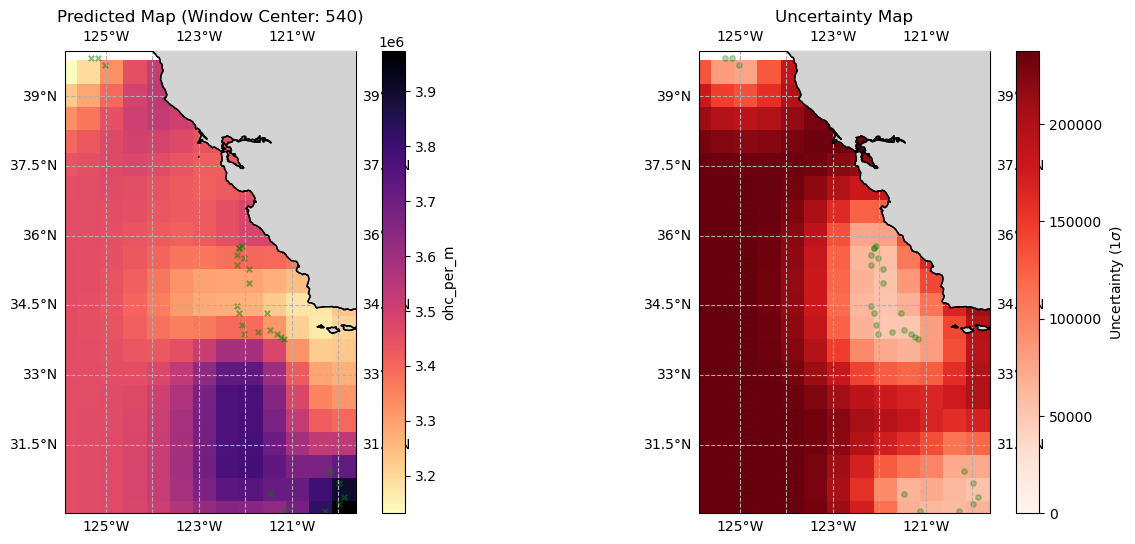

In [12]:
ag.plot_kriging_snapshot(df_ohc_500m, results_df, target_date=550)

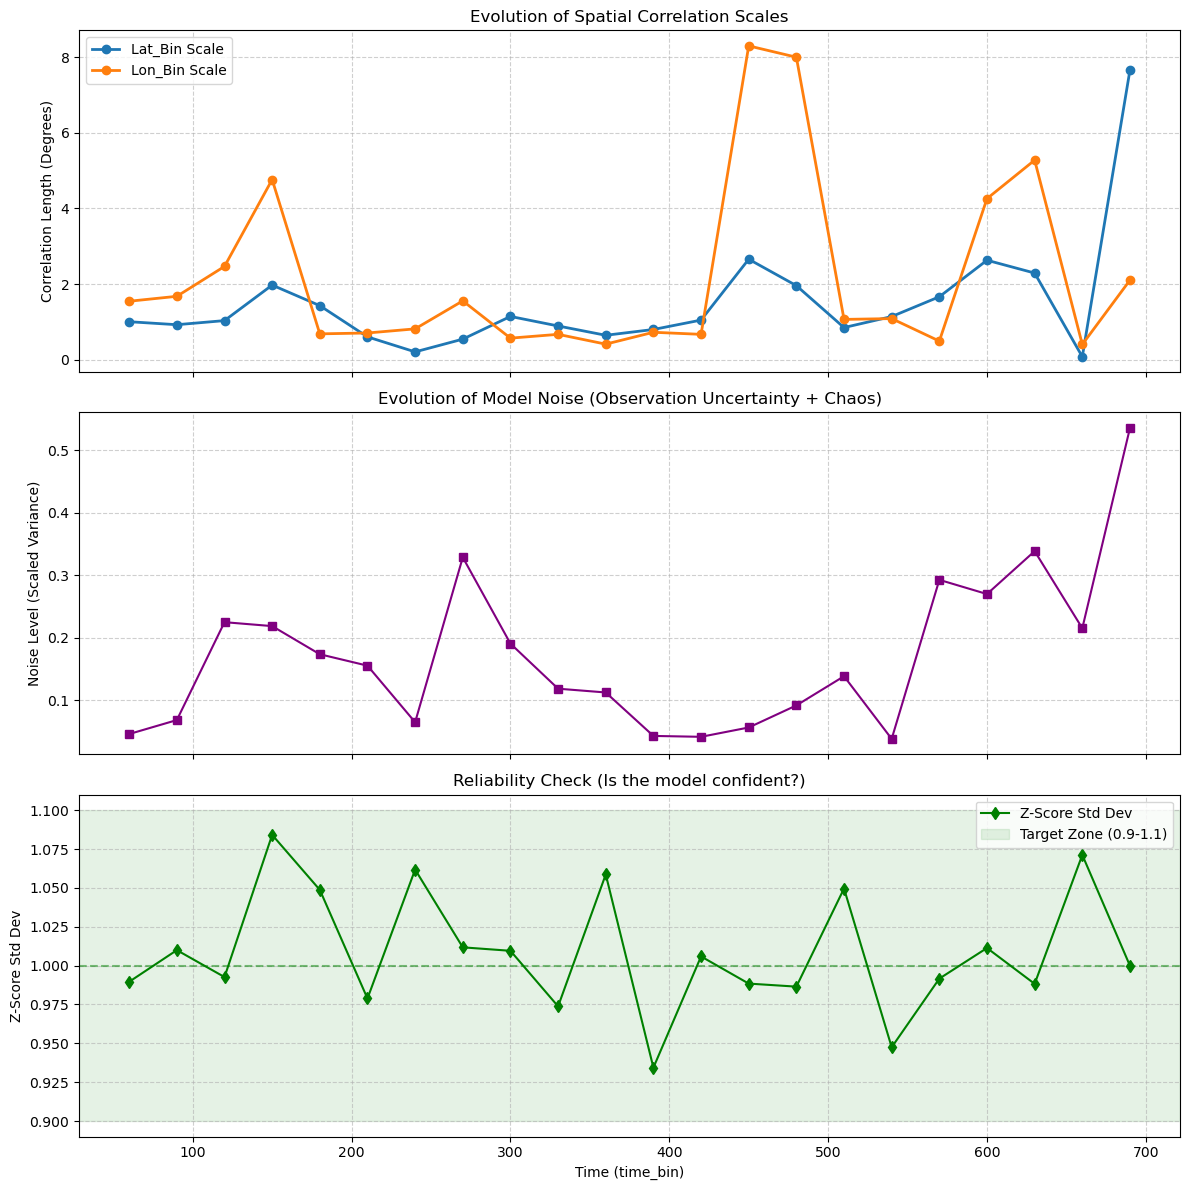

In [13]:
ag.plot_physics_history(results_df, time_unit='time_bin')